# __05 Model Evaluation and Improvement__

To evaluate our supervised models, so far we have split our dataset into a training set
and a test set using the `train_test_split` function, built a model on the training set
by calling the fit method, and evaluated it on the test set using the score method,
which for classification computes the fraction of correctly classified samples. Here’s
an example of that process:

In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state = 0)

# split data nad labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# evaluate the model in the test set
print(f'test set score: {logreg.score(X_test, y_test):.2f}')

test set score: 0.88


/home/concerta/.virtualenvs/lab/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In this chapter, we will expand on two aspects of this evaluation. We will first intro‐
duce cross-validation, a more robust way to assess generalization performance, and
discuss methods to evaluate classification and regression performance that go beyond
the default measures of accuracy and $R^2$ provided by the score method.

## __Cross Validation__

_Cross-Validation_ is a statistical method of evaluating generalization
performance that is more stable and thorough than using a split into
a training and a test set. I cross-validation, the data is instead split
repeatedly and multiple models are trained.

The most commonly used version of cross-validation is __k-fold cross validation__, where _k_
is a user specified number. When performing _k-fold cross validation_, the data is first
partitioned into _k_ parts of (approximately) equal size, called _folds_.
Next, a sequence of models is trained. The first mdoel is trained using the first
fold as the test set, and the remaining folds 2-_k_ are used as the training set.

The model is built using the data in folds 2–k, and then the accuracy is evaluated on fold 1. Then
another model is built, this time using fold 2 as the test set and the data in folds 1, 3,
4, ..., _k_ as the training set. This process is repeated using folds 3, 4, ...,  _k_ as test sets.
For each of these five splits of the data into training and test sets, we compute the
accuracy. In the end, we have collected _k_ accuracy values.

/home/concerta/.virtualenvs/lab/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/concerta/.virtualenvs/lab/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 

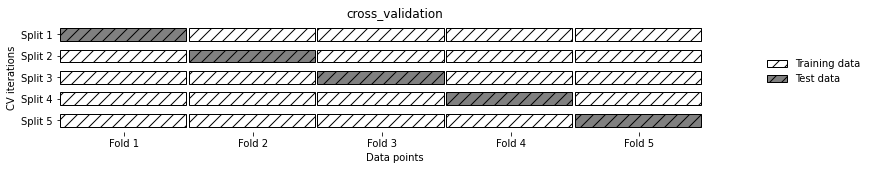

In [3]:
import mglearn
mglearn.plots.plot_cross_validation()

In [4]:
# prettu print numpy floats
import numpy as np
np.set_printoptions(precision = 3)

In [5]:
# applying cross-validation in scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter = 9000)

scores = cross_val_score(logreg, iris.data, iris.target)
print(f'cross-validation scores: {scores}')

cross-validation scores: [0.967 1.    0.933 0.967 1.   ]


In [6]:
# averag cross validation
print(f'average cross-validation score: {scores.mean():.3f}')

average cross-validation score: 0.973


Using the mean cross-validation we can conclude that we expect the model to be
around 96% accurate on average. Looking at all five scores produced by the five-fold
cross-validation, we can also conclude that there is a relatively high variance in the
accuracy between folds, ranging from 100% accuracy to 90% accuracy. This could
imply that the model is very dependent on the particular folds used for training, but it
could also just be a consequence of the small size of the dataset.

There are several benefits to using cross-validation instead of a single split into a
training and a test set. First, remember that train_test_split performs a random
split of the data. Imagine that we are “lucky” when randomly splitting the data, and
all examples that are hard to classify end up in the training set. In that case, the test
set will only contain “easy” examples, and our test set accuracy will be unrealistically
high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-
classify examples in the test set and consequently obtain an unrealistically low score.
However, when using cross-validation, each example will be in the training set exactly
once: each example is in one of the folds, and each fold is the test set once. Therefore,
the model needs to generalize well to all of the samples in the dataset for all of the
cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensi‐
tive our model is to the selection of the training dataset. For the iris dataset, we saw
accuracies between 90% and 100%. This is quite a range, and it provides us with an
idea about how the model might perform in the worst case and best case scenarios
when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is
that we use our data more effectively. When using train_test_split , we usually use
75% of the data for training and 25% of the data for evaluation. When using five-fold
cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the
model. When using 10-fold cross-validation, we can use nine-tenths of the data
(90%) to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are
now training k models instead of a single model, cross-validation will be roughly k
times slower than doing a single split of the data.

## Stratified k-Fold Cross-Validation and Other Strategies

scikit-learn does not use vanilla k-fold crossvalidation for classifica‐
tion, but rather uses stratified k-fold cross-validation. In stratified cross-validation, we
split the data such that the proportions between classes are the same in each fold as
they are in the whole dataset.

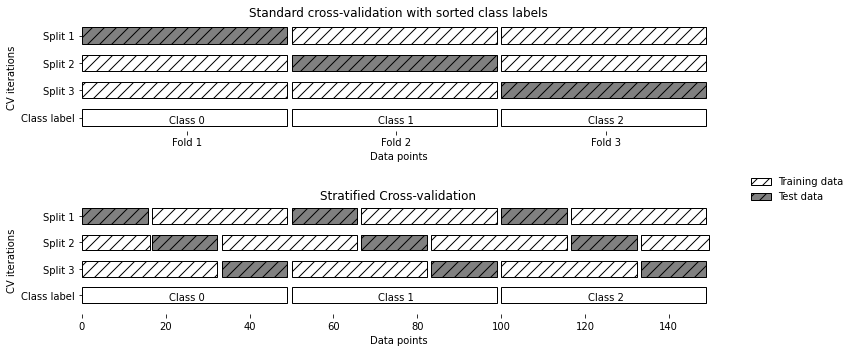

In [7]:
mglearn.plots.plot_stratified_cross_validation()

It is usually a good idea to use stratified k-fold cross-validation instead of k-fold
cross-validation to evaluate a classifier, because it results in more reliable estimates of
generalization performance. In the case of only 10% of samples belonging to class B,
using standard k-fold cross-validation it might easily happen that one fold only con‐
tains samples of class A. Using this fold as a test set would not be very informative
about the overall performance of the classifier.

For regression, scikit-learn uses the standard k-fold cross-validation by default. It
would be possible to also try to make each fold representative of the different values
the regression target has, but this is not a commonly used strategy and would be sur‐
prising to most users.

#### More control over cross-validation

We saw earlier that we can adjust the number of folds that are used in
cross_val_score using the cv parameter. However, scikit-learn allows for much
finer control over what happens during the splitting of the data by providing a cross-
validation splitter as the cv parameter. For most use cases, the defaults of k-fold cross-
validation for regression and stratified k-fold for classification work well, but there
are some cases where you might want to use a different strategy. Say, for example, we
want to use the standard k-fold cross-validation on a classification dataset to repro‐
duce someone else’s results. To do this, we first have to import the KFold splitter class
from the model_selection module and instantiate it with the number of folds we
want to use:

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 3)
print(f'cross validation scores: {cross_val_score(logreg, iris.data, iris.target, cv = kfold)}')

cross validation scores: [0. 0. 0.]


This way, we can verify that it is indeed a really bad idea to use three-fold (nonstrati‐
fied) cross-validation on the iris dataset.

In [9]:
# shuffle data in Kfold
kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)
print('cross-validation scores: ', cross_val_score(logreg, iris.data, iris.target, cv = kfold))

cross-validation scores:  [0.98 0.96 0.96]


Another frequently used cross-validation method is __leave-one-out__. You can think of
leave-one-out cross-validation as k-fold cross-validation where each fold is a single
sample. For each split, you pick a single data point to be the test set. This can be very
time consuming, particularly for large datasets, but sometimes provides better estimates on small datasets:

In [10]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv = loo)
print('number of cv iterations: ', len(scores))
print(f'mean accuracy: {scores.mean():.3f}')

number of cv iterations:  150
mean accuracy: 0.967


### Shuffle-Split Cross-Validation

Another, very flexible strategy for cross-validation is shuffle-split cross-validation. In
shuffle-split cross-validation, each split samples `train_size` many points for the
training set and `test_size` many (disjoint) point for the test set. This splitting is
repeated `n_iter` times.

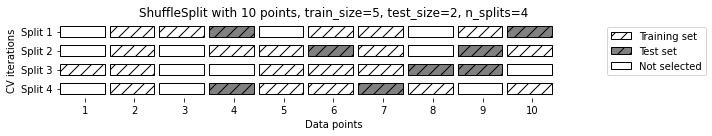

In [11]:
mglearn.plots.plot_shuffle_split()

In [12]:
# split dataset into 50% training set
# and 50% test set for 10 iterations
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size = 0.5, train_size = 0.5, n_splits = 10)
scores = cross_val_score(logreg, iris.data, iris.target, cv = shuffle_split)
print(f'cross-validation scores: {scores}')

cross-validation scores: [0.973 0.96  0.947 0.933 0.987 0.987 0.947 0.973 0.907 0.987]


Shuffle-split cross-validation allows for control over the number of iterations inde‐
pendently of the training and test sizes, which can sometimes be helpful. It also allows
for using only part of the data in each iteration, by providing `train_size` and
`test_size` settings that don’t add up to one. Subsampling the data in this way can be
useful for experimenting with large datasets.

### __Cross-Validation with groups__

Another very common setting for cross-validation is when there are groups in the
data that are highly related. Say you want to build a system to recognize emotions
from pictures of faces, and you collect a dataset of pictures of 100 people where each
person is captured multiple times, showing various emotions. The goal is to build a
classifier that can correctly identify emotions of people not in the dataset. You could
use the default stratified cross-validation to measure the performance of a classifier
here. However, it is likely that pictures of the same person will be in both the training
and the test set. It will be much easier for a classifier to detect emotions in a face that
is part of the training set, compared to a completely new face. To accurately evaluate
the generalization to new faces, we must therefore ensure that the training and test
sets contain images of different people.

To achieve this, we can use `GroupKFold`, which takes an array of groups ar argument that we can use to
indicate which person is in the image. The `groups` array here indicates groups in the data
that should not be split whenc reating the training ant test sets, and should no be
confused with the class label.

This example of groups in the data is common in medical applications, where you
might have multiple samples from the same patient, but are interested in generalizing
to new patients. Similarly, in speech recognition, you might have multiple recordings
of the same speaker in your dataset, but are interested in recognizing speech of new
speakers.

The following is an example of using a synthetic dataset with a grouping given by the
groups array. The dataset consists of 12 data points, and for each of the data points,
groups specifies which group (think patient) the point belongs to. The groups specify
that there are four groups, and the first three samples belong to the first group, the
next four samples belong to the second group, and so on:

In [13]:
from sklearn.model_selection import GroupKFold

# create synthetic dataset
X, y = make_blobs(n_samples = 12, random_state = 0)

# assume the first three samples belong to the same group
# then the next four, etc
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv = GroupKFold(n_splits = 3))
print('cross validation scores: ', scores)

cross validation scores:  [0.75  0.6   0.667]


As you can see, for each split, each group is either entirely in the training set or
entirely in the test set:

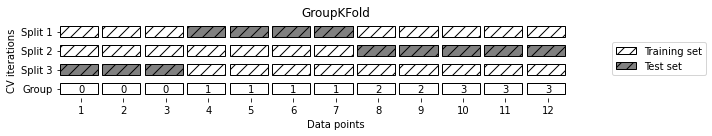

In [14]:
mglearn.plots.plot_group_kfold()

## __Grid Search__

Now that we know how to evaluate how well a model generalizes, we can take the
next step and improve the model’s generalization performance by tuning its parame‐
ters.
Finding the values of the important parameters of a
model (the ones that provide the best generalization performance) is a tricky task, but
necessary for almost all models and datasets. Because it is such a common task, there
are standard methods in scikit-learn to help you with it. The most commonly used
method is grid search, which basically means trying all possible combinations of the
parameters of interest.


### __Simple Grid Search__

We can implement a simple grid search just as `for` loops over the two parameters,
training and evaluating a classifeir for each combination:


In [15]:
# naive grid search implementation
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

print(f'shape of training set: {X_train.shape}', end = '   |   ')
print(f'shape of test set: {X_test.shape}')

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        
        #evaluate the SVC in the test set
        score = svm.score(X_test, y_test)
        
        #if we got a better score, store the score and params
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
    
print(f'best score: {best_score:.2f}')
print(f'best parameters: {best_parameters}')

shape of training set: (112, 4)   |   shape of test set: (38, 4)
best score: 0.97
best parameters: {'C': 100, 'gamma': 0.001}


### __The Danger of Overfitting the Parameters and Validation Set__

Given this resutl, we might be tempted to report that we dounf a model that
performs 97% accuracy on out dataset. However, this claom could be overly
optimistic (or just wrong), for thr following reason: we tried many
different parameters and selected the one with best accuracy on the test set, but
this accuracy won't necessarily carry over to new data. Because we used the test data
to adjust the parameters, we can no longer use it to asses how good the model is.
This is the same reason we needed to split the data into training and test
sets int he first place; we need an independent dataset to evaluateç, one that
was not used to create the model.

One way to resolve this problem is to split the data again, so we have three sets: the
training set to build the model, the validation (or development) set to select the
parameters of the model, and the test set to evaluate the performance of the selected
parameters.

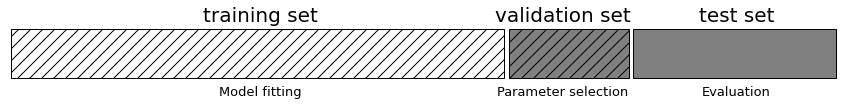

In [16]:
mglearn.plots.plot_threefold_split()

After selecting the best parameters using the validation set, we can rebuild a 
model using the parameter serings we found, but now training on both the training data
and the validation data. This way, we can use as mich data as possible
to build our model.


In [17]:
# implementation of the addition of validation set
from sklearn.svm import SVC

# split data into train + validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

# split train + validation set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state = 1
)

print(f'shape of training set: {X_train.shape}', end = '  |  ')
print(f'shape of validation set: {X_valid.shape}', end = '  |  ')
print(f'shape of test set: {X_test.shape}')


best_score = 0
model_parameters = [0.001, 0.001, 0.1, 1, 10, 100]
for gamma in model_parameters:
    for C in model_parameters:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        svm.fit(X_train, y_train)
        
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model in the combined training and validation set
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)

print(f"Best score on validation set: {best_score:.2f}")
print("Best parameters: ", best_parameters)
print(f"Test set score with best parameters: {test_score:.2f}")

shape of training set: (84, 4)  |  shape of validation set: (28, 4)  |  shape of test set: (38, 4)
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


The best score on the validation set is 96%: slightly lower than before, probably
because we used less data to train the model ( X_train is smaller now because we split
our dataset twice). However, the score on the test set—the score that actually tells us
how well we generalize—is even lower, at 92%. So we can only claim to classify new
data 92% correctly, not 97% correctly as we thought before.

The distinction between the training set, validation set, and test set is fundamentally
important to applying machine learning methods in practice. Any choices made
based on the test set accuracy “leak” information from the test set into the model.
Therefore, it is important to keep a separate test set, which is only used for the final
evaluation. It is good practice to do all exploratory analysis and model selection using
the combination of a training and a validation set, and reserve the test set for a final
evaluation—this is even true for exploratory visualization. Strictly speaking, evaluat‐
ing more than one model on the test set and choosing the better of the two will result
in an overly optimistic estimate of how accurate the model is.

## __Grid Search with Cross-Valdiation__

While the method of splitting the data into a training, a validation, and a test set
that we just saw is workable, and relatively commonly used, it is quite sensitive to
how exactly the data is split.

For a better estimate of the generalziation performance, isntead of using
a single split into a training and a validation set, we can use cross-validation to
evaluate the performance of each parameter combination.

In [18]:
# implementation of the addition of validation set
from sklearn.svm import SVC

# split data into train + validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

print(f'shape of train-validation set: {X_trainval.shape}', end = '  |  ')
print(f'shape of test set: {X_test.shape}')


best_score = 0
model_parameters = [0.001, 0.01, 0.1, 1, 10, 100]
for gamma in model_parameters:
    for C in model_parameters:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma = gamma, C = C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv = 5)
        
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model in the combined training and validation set
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)

print(f"Best score on validation set: {best_score:.2f}")
print("Best parameters: ", best_parameters)
print(f"Test set score with best parameters: {test_score:.2f}")

shape of train-validation set: (112, 4)  |  shape of test set: (38, 4)
Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


For each parameter setting (only a subset is shown), five accuracy values are compu‐
ted, one for each split in the cross-validation. Then the mean validation accuracy is
computed for each parameter setting.

The overall process of splitting the data, running the grid srach
and evaluating final parametes is depcited in the next diagram:

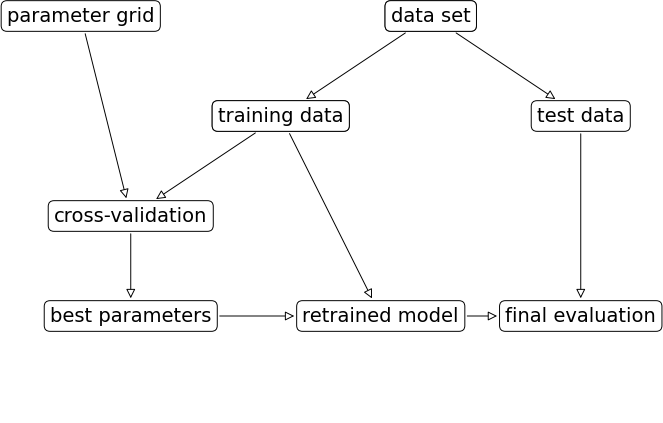

In [19]:
mglearn.plots.plot_grid_search_overview()

Because grid search with cross-validation is such a commonly used method to adjust
parameters, `scikit-learn` provides the `GridSearchCV` class, which implements it in
the form of an estimator. To use the GridSearchCV class, you first need to specify the
parameters you want to search over using a dictionary. `GridSearchCV` will then per‐
form all the necessary model fits. The keys of the dictionary are the names of parame‐
ters we want to adjust (as given when constructing the model—in this case, C and
gamma ), and the values are the parameter settings we want to try out.

In [20]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

print(f'parameter grid:\n{param_grid}')

# now we can instntiate GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid = param_grid, cv = 5)

# GridSearchCV will use cross-validation in place of the split into a training
# and validation set that we used before. However, we still need to split
# the data into a training and a test set, to avoid overfitting the parameters:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state = 0
)

# The grid_search object that we created behaves just like a
# classifier; we can call the standard methods fit , predict , and score on it.
grid_search.fit(X_train, y_train)

parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
print(f'test set score: {grid_search.score(X_test, y_test):.3f}')

test set score: 0.974


Choosing the parameters using cross-validation, we actually found a model that ach‐
ieves 97% accuracy on the test set. The important thing here is that we did not use the
test set to choose the parameters. The parameters that were found are scored in the
`best_params_` attribute, and the best cross-valdiation accuracy is stored in
`best_score_`

In [22]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


__Again, be careful not to confuse best_score_ with the generaliza‐
tion performance of the model as computed by the score method
on the test set. Using the score method (or evaluating the output of
the predict method) employs a model trained on the whole train‐
ing set. The best_score_ attribute stores the mean cross-validation
accuracy, with cross-validation performed on the training set.__

In [23]:
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Because `grid_search` itself has predict and score methods, using `best_estimator_`
is not needed to make predictions or evaluate the model.

### __Analyzing the result of cross-validation__

We can then inspect the results of the cross-validated
grid search, and possibly expand our search. The results of a grid search can be found
in the cv_results_ attribute, which is a dictionary storing all aspects of the search.
It contains a lot of details, as you can see in the following output, and is best looked at
after converting it to a pandas DataFrame: 

In [24]:
import pandas as pd

# convert to dataframe
results = pd.DataFrame(grid_search.cv_results_)

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000909,0.000257,0.000506,0.000173,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.000891,0.000389,0.000388,0.000167,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.000769,0.000077,0.000396,0.000049,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000848,0.000080,0.000439,0.000092,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000589,0.000087,0.000268,0.000016,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


As we were searching a two-dimensional grid of
parameters ( C and gamma ), this is best visualized as a heat map

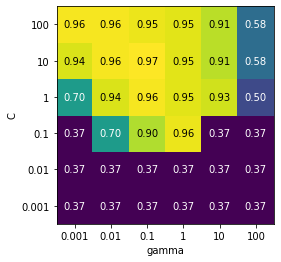

In [25]:
import matplotlib.pyplot as plt
scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-valdation scores
mglearn.tools.heatmap(scores, xlabel = 'gamma', xticklabels=param_grid['gamma'],
                      ylabel = 'C', yticklabels=param_grid['C'], cmap = 'viridis')
plt.show()

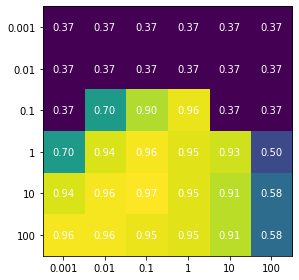

In [26]:
fig, ax = plt.subplots()
plt.imshow(scores)
# Loop over data dimensions and create text annotations.
for i in range(len(param_grid['C'])):
    for j in range(len(param_grid['gamma'])):
        text = ax.text(j, i, f'{scores[i, j]:.2f}', ha="center", va="center", color="w")

ax.set_xticks(np.arange(len(param_grid['gamma'])))
ax.set_yticks(np.arange(len(param_grid['C'])))

ax.set_xticklabels(param_grid['gamma'])
ax.set_yticklabels(param_grid['C'])

fig.tight_layout()
plt.show()

In [27]:
param_grid['C']

[0.001, 0.01, 0.1, 1, 10, 100]

Each point in the heat map corresponds to one run of cross-validation, with a partic‐
ular parameter setting. The color encodes the cross-validation accuracy, with light
colors meaning high accuracy and dark colors meaning low accuracy. You can see
that SVC is very sensitive to the setting of the parameters. For many of the parameter
settings, the accuracy is around 40%, which is quite bad; for other settings the accu‐
racy is around 96%. We can take away from this plot several things. First, the parame‐
ters we adjusted are very important for obtaining good performance. Both parameters
( C and gamma ) matter a lot, as adjusting them can change the accuracy from 40% to
96%. Additionally, the ranges we picked for the parameters are ranges in which we
see significant changes in the outcome. It’s also important to note that the ranges for
the parameters are large enough: the optimum values for each parameter are not on
the edges of the plot.

Now let’s look at some plots where the result is less ideal,
because the search ranges were not chosen properly:

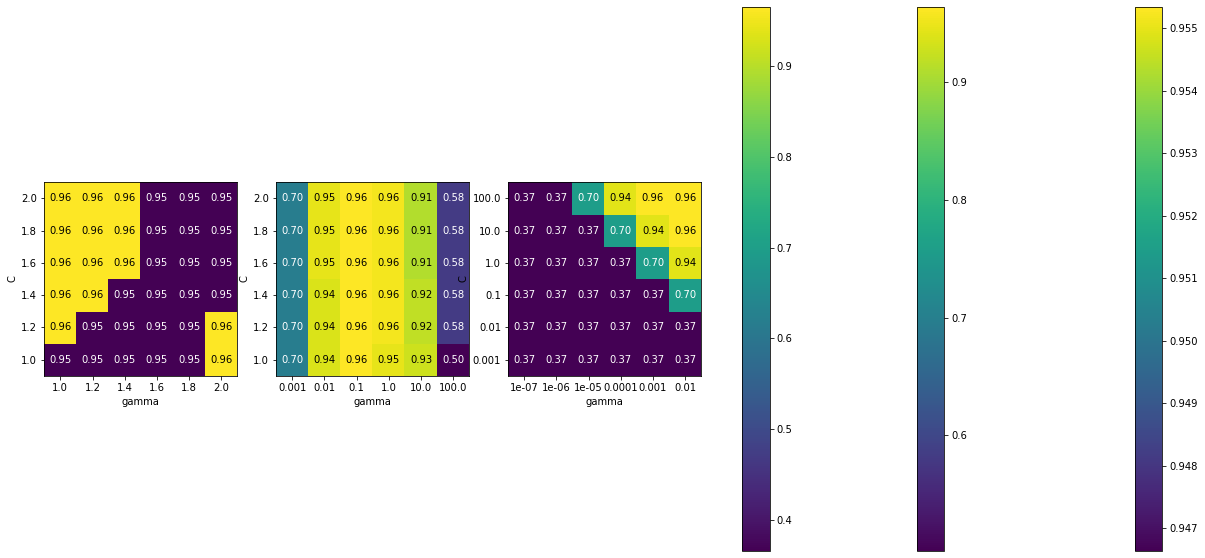

In [28]:
fig, axes = plt.subplots(1, 3, figsize = (23, 10))

param_grid_linear = {
    'C': np.linspace(1, 2, 6),
    'gamma': np.linspace(1, 2, 6)
}

param_grid_one_log = {
    'C': np.linspace(1, 2, 6),
    'gamma': np.logspace(-3, 2, 6)
}

param_grid_range = {
    'C': np.logspace(-3, 2, 6),
    'gamma': np.logspace(-7, -2, 6)
}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    
    # plot the mean cross-validation scores
    scores_images = mglearn.tools.heatmap(
        scores, xlabel = 'gamma', ylabel = 'C', xticklabels = param_grid['gamma'],
        yticklabels = param_grid['C'], cmap = 'viridis', ax = ax
    )
    
    plt.colorbar(scores_images, ax = axes.tolist())

The first panel shows no changes at all, with a constant color over the whole parame‐
ter grid. In this case, this is caused by improper scaling and range of the parameters C
and gamma . However, if no change in accuracy is visible over the different parameter
settings, it could also be that a parameter is just not important at all. It is usually good
to try very extreme values first, to see if there are any changes in the accuracy as a
result of changing a parameter.

The second panel shows a vertical stripe pattern. This indicates that only the setting
of the gamma parameter makes any difference. This could mean that the gamma parameter
is searching over interesting values but the C parameter is not—or it could mean
the C parameter is not important.

The third panel shows changes in both C and gamma . However, we can see that in the
entire bottom left of the plot, nothing interesting is happening. We can probably
exclude the very small values from future grid searches. The optimum parameter setting
is at the top right. As the optimum is in the border of the plot, we can expect that
there might be even better values beyond this border, and we might want to change
our search range to include more parameters in this region.
Tuning the parameter grid based on the cross-validation scores is perfectly fine, and a
good way to explore the importance of different parameters. However, you should
not test different parameter ranges on the final test set—as we discussed earlier, eval
uation of the test set should happen only once we know exactly what model we want
to use.

### Search over spaces that are not grids
In some cases, trying all possible combinations of all parameters as GridSearchCV
usually does, is not a good idea. For example, SVC has a kernel parameter, and
depending on which kernel is chosen, other parameters will be relevant. If ker
nel='linear' , the model is linear, and only the C parameter is used. If kernel='rbf' ,
both the C and gamma parameters are used (but not other parameters like degree ). In
this case, searching over all possible combinations of C , gamma , and kernel wouldn’t
make sense: if kernel='linear' , gamma is not used, and trying different values for
gamma would be a waste of time. To deal with these kinds of “conditional” parameters,
GridSearchCV allows the param_grid to be a list of dictionaries. Each dictionary in the
list is expanded into an independent grid. A possible grid search involving kernel and
parameters could look like this:

In [29]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]

from pprint import pprint
pprint(f'list of grids:\n{param_grid}')

('list of grids:\n'
 "[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, "
 "0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, "
 '10, 100]}]')


In [30]:
grid_search = GridSearchCV(SVC(), param_grid, cv = 5)
grid_search.fit(X_train, y_train)

print(f'best perameters: {grid_search.best_params_}')
print(f'best cross-validation score: {grid_search.best_score_:.2f}')

best perameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best cross-validation score: 0.97


In [31]:
# let's look at the cv_results_ again
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000907564,0.000750351,0.000861597,0.000644302,0.000694561,0.000703621,0.000657415,0.000674009,0.000681496,0.000630808,...,0.00042367,0.000585651,0.000679636,0.00100698,0.000528193,0.000528002,0.000472689,0.000360203,0.000466537,0.000476122
std_fit_time,0.000217938,0.000123733,0.000167928,0.000125853,0.000108162,6.02867e-05,0.000109821,0.000103434,9.10725e-05,0.000184323,...,5.23519e-05,0.000143163,7.0261e-05,0.000200923,5.20388e-05,7.13267e-05,3.67819e-05,8.15433e-06,0.000103964,7.58985e-05
mean_score_time,0.000471926,0.000468779,0.000443554,0.000275612,0.000357533,0.000353527,0.000462961,0.000302935,0.000375414,0.00028019,...,0.000328732,0.000294685,0.000284624,0.000381851,0.000277376,0.00032897,0.000279808,0.000238705,0.000285149,0.000320292
std_score_time,0.000148062,0.000170378,0.000110118,2.3051e-05,0.000126627,6.62974e-05,0.000193121,3.41219e-05,9.91817e-05,2.99397e-05,...,0.000142873,4.08964e-05,4.57631e-05,8.02885e-05,4.48713e-05,0.00012736,2.43377e-05,1.93724e-05,6.77047e-05,0.00015097
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


### __Nested Cross-Validation__

In the preceding examples, we went form using a single split of the data
into training, validation, and test sets to splitting the data into training and
test sets and then performing cross-validation on the training set. But when using
`GridSearchCV` as described earlier, we still have a single split of the data into training
and test sets, which might take our results unstable and make us depend to much on this
single split of the data. We can go a step further, and instead of splitting the original data
into training and test sets once, use multiple splits of cross-validation. This will result
in what is called nested cross-validation. In nested cross-validation, there is an outer
loop over splits of the data into training and test sets. For each of them, a grid search
is run (which might result in different best parameters for each split in the outer
loop). Then, for each outer split, the test set score using the best settings is reported.

The result of this procedure is a list of scores - not a model, and not a parameter setting-
The scores tell us how well a model generalizes, given the best parameters found by the grid.
As it doens't provide a model that can be used on new data, nested cross-valdiation is rarely
used when looking for a predictive model to apply to future data.
However, it can be useful for evaluating how well a given model works on
a particular dataset.


In [32]:
# implementing nested cross-validation in scikit-learn is
# straightforward
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv = 5),
                         iris.data, iris.target, cv = 5, verbose = 2,
                         n_jobs = 6)
print('cross-validation scores: ', scores)
print('mean cross-validation score. ', scores.mean())

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


cross-validation scores:  [0.967 1.    0.9   0.967 1.   ]
mean cross-validation score.  0.9666666666666668


[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


The result of our nested cross-validation can be summarized as "SVC can achieve ~98% mean
cross valdiation accuracy on the `iris` dataset" - nothing more, nothing less.

Here, we used stratified five-fold cross-validation in both the inner and the outer
loop. As our param_grid contains 36 combinations of parameters, this results in a
whopping 36 * 5 * 5 = 900 models being built, making nested cross-validation a very
expensive procedure. Here, we used the same cross-validation splitter in the inner
and the outer loop; however, this is not necessary and you can use any combination
of cross-validation strategies in the inner and outer loops. It can be a bit tricky to
understand what is happening in the single line given above, and it can be helpful to
visualize it as for loops, as done in the following simplified implementation:

In [33]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # for each split of the data in the outer cross-validation
    # (split mehtod returns indices)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_params = {}
        best_score = -np.inf
        
        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score voer inner splits
            cv_scores = []
            
            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(
                X[training_samples], y[training_samples]
            ):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
                
            # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember params
                best_score = mean_score
                best_params = parameters
        
        # build a classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        
        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    
    return np.array(outer_scores)

In [34]:
# run this fucntion on iris
from sklearn.model_selection import ParameterGrid, StratifiedKFold

scores = nested_cv(
    iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid)
)

print(f'cross validation scores: {scores}')

cross validation scores: [0.967 1.    0.967 0.967 1.   ]


While running a grid search over many parameters and on large datasets can be com‐
putationally challenging, it is also embarrassingly parallel. This means that building a
model using a particular parameter setting on a particular cross-validation split can
be done completely independently from the other parameter settings and models.
This makes grid search and cross-validation ideal candidates for parallelization over
multiple CPU cores or over a cluster. You can make use of multiple cores in Grid
SearchCV and cross_val_score by setting the n_jobs parameter to the number of
CPU cores you want to use. You can set n_jobs=-1 to use all available cores.

You should be aware that scikit-learn does not allow nesting of parallel operations.
So, if you are using the n_jobs option on your model (for example, a random forest),
you cannot use it in GridSearchCV to search over this model. If your dataset and
model are very large, it might be that using many cores uses up too much memory,
and you should monitor your memory usage when building large models in parallel.

## __Evaluation Metrics and Scoring__

So far, we have evaluated classification performance using accuracy (the fraction of
correctly classified samples) and regression performance using R 2 . However, these are
only two of the many possible ways to summarize how well a supervised model per‐
forms on a given dataset. In practice, these evaluation metrics might not be appropriate
for your application, and it is important to choose the right metric when selecting
between models and adjusting parameters.

When selecting a metric, you should always have the end goal of the machine learn
ing application in mind. In practice, we are usually interested not just in making
accurate predictions, but in using these predictions as part of a larger decision-
making process. Before picking a machine learning metric, you should think about
the high-level goal of the application, often called the business metric. The conse
quences of choosing a particular algorithm for a machine learning application are
called the business impact. Maybe the high-level goal is avoiding traffic accidents, or
decreasing the number of hospital admissions. It could also be getting more users for
your website, or having users spend more money in your shop. When choosing a
model or adjusting parameters, you should pick the model or parameter values that
have the most positive influence on the business metric. Often this is hard, as assess‐
ing the business impact of a particular model might require putting it in production
in a real-life system.

In the early stages of development, and for adjusting parameters, it is often infeasible
to put models into production just for testing purposes, because of the high business
or personal risks that can be involved. Imagine evaluating the pedestrian avoidance
capabilities of a self-driving car by just letting it drive around, without verifying it
first; if your model is bad, pedestrians will be in trouble! Therefore we often need to
find some surrogate evaluation procedure, using an evaluation metric that is easier to
compute. For example, we could test classifying images of pedestrians against non-
pedestrians and measure accuracy. Keep in mind that this is only a surrogate, and it
pays off to find the closest metric to the original business goal that is feasible to evalu‐
ate. This closest metric should be used whenever possible for model evaluation and
selection. The result of this evaluation might not be a single number—the conse‐
quence of your algorithm could be that you have 10% more customers, but each cus‐
tomer will spend 15% less—but it should capture the expected business impact of
choosing one model over another.
In this section, we will first discuss metrics for the important special case of binary
classification, then turn to multiclass classification and finally regression.

### __Kind of errors__
Often, accuracy is not a good measure of predictive performance, as the number of
mistakes we make does not contain all the information we are interested in. Imagine
an application to screen for the early detection of cancer using an automated test. If
the test is negative, the patient will be assumed healthy, while if the test is positive, the
patient will undergo additional screening. Here, we would call a positive test (an indi‐
cation of cancer) the positive class, and a negative test the negative class. We can’t
assume that our model will always work perfectly, and it will make mistakes. For any
application, we need to ask ourselves what the consequences of these mistakes might
be in the real world.

One possible mistake is that a healthy patient will be classified as positive,
leading to additional testing. This leads to some costs and inconvenience for the patient
(and possibly some mental distress). An incorrect positive prediction is called
a _false positive_. Thhe other possible mistake is that a sick patient will be
classified as negative, and will not receive further tests and treatment.

The undiagnosed cancer might lead to
serious health issues, and could even be fatal. A mistake of this kind—an incorrect
negative prediction—is called a _false negative_.

In statistics, a false positive is also known as _type I error_ and a false negative as _type II error_.

While this is a particularly drastic example, the consequence of false positives and
false negatives are rarely the same. In commercial applications, it might be possible to
assign dollar values to both kinds of mistakes, which would allow measuring the error
of a particular prediction in dollars, instead of accuracy. This might be much more
meaningful for making business decisions on which model to use.

#### __Imbalanced datasets__

Types of errors play an important role when one of two classes is much more frequent
than the other one. This is very common in practice; a good example is click-through
prediction, where each data point represents an “impression,” an item that was shown
to a user. This item might be an ad, or a related story, or a related person to follow on
a social media site. The goal is to predict whether, if shown a particular item, a user
will click on it (indicating they are interested). Most things users are shown on the
Internet (in particular, ads) will not result in a click. You might need to show a user
100 ads or articles before they find something interesting enough to click on. This
results in a dataset where for each 99 “no click” data points, there is 1 “clicked” data
point; in other words, 99% of the samples belong to the “no click” class. Datasets in
which one class is much more frequent than the other are often called imbalanced
datasets, or datasets with imbalanced classes. In reality, imbalanced data is the norm,
and it is rare that the events of interest have equal or even similar frequency in the
data.

Now let’s say you build a classifier that is 99% accurate on the click prediction task.
What does that tell you? 99% accuracy sounds impressive, but this doesn’t take the
class imbalance into account. You can achieve 99% accuracy without building a
machine learning model, by always predicting “no click.” On the other hand, even
with imbalanced data, a 99% accurate model could in fact be quite good. However,
accuracy doesn’t allow us to distinguish the constant “no click” model from a poten‐
tially good model.
To illustrate, we’ll create a 9:1 imbalanced dataset from the digits dataset, by classify‐
ing the digit 9 against the nine other classes:

In [35]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state = 0
)

In [36]:
# we can use the DummyClassifier to always predict
# the majority class, to see how uninformative accuracy can be
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print(f'unique predicted labels: {np.unique(pred_most_frequent)}')
print(f'test score: {dummy_majority.score(X_test, y_test):.3f}')

unique predicted labels: [False]
test score: 0.896


We obtained close to 90% accuracy without learning anything. This might seem strik‐
ing, but think about it for a minute. Imagine someone telling you their model is 90%
accurate. You might think they did a very good job. But depending on the problem,
that might be possible by just predicting one class! Let’s compare this against using an
actual classifier:

In [37]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(f'test score: {tree.score(X_test, y_test):.2f}')

test score: 0.92


According to accuracy, the `DecisionTreeClassifier` is noly slightly better than
the constant predictor. This could indicate eother that something is wrong
with how we used `DeisionTreeClassifier`, or that accuracy is in fact not a good
measure here.

For comparison purposes, let's evaluate two more classifiers, `LogisticRegression`
and the default `DummyClassifier`, wchih makes random predictions but produces
classes with same propoertions as in the training set

In [38]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print(f'dummy score: {dummy.score(X_test, y_test):.2f}')

logreg = LogisticRegression(C = 0.1, max_iter = 9000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)

print(f'logreg score: {logreg.score(X_test, y_test):.2f}')

dummy score: 0.83
logreg score: 0.98


/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


The dummy classifier that produces random output is clearly the worst of the lot
(according to accuracy), while `LogisticRegression` produces very good results.
However, even the random classifier yields over 80% accuracy. This makes it very
hard to judge which of these results is actually helpful. The problem here is that accu‐
racy is an inadequate measure for quantifying predictive performance in this imbal‐
anced setting. For the rest of this chapter, we will explore alternative metrics that
provide better guidance in selecting models. In particular, we would like to have met‐
rics that tell us how much better a model is than making “most frequent” predictions
or random predictions, as they are computed in `pred_most_frequent` and
`pred_dummy` . If we use a metric to assess our models, it should definitely be able to
weed out these nonsense predictions.

### Confusion matrices

One of the most comprehensive ways to represent the result of evaluating binary clas‐
sification is using confusion matrices. Let’s inspect the predictions of LogisticRegres
sion from the previous section using the confusion_matrix function. We already
stored the predictions on the test set in `pred_logreg` :

In [39]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print(f'confusion matrix:\n{confusion}')

confusion matrix:
[[402   1]
 [  6  41]]


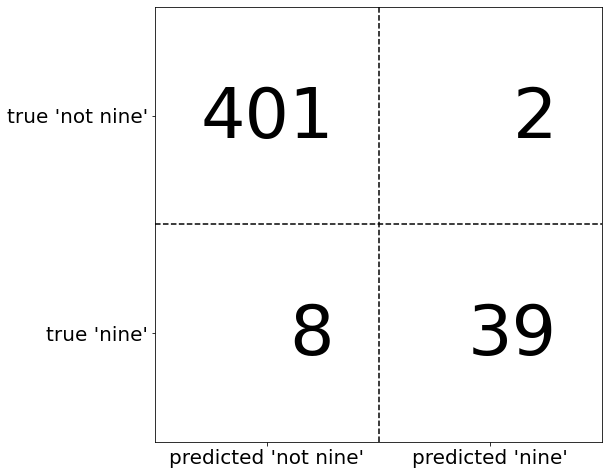

In [40]:
mglearn.plots.plot_confusion_matrix_illustration()

Entries on the main diagonal of the confusion matrix correspond to correct classifi‐
cations, while other entries tell us how many samples of one class got mistakenly clas‐
sified as another class.
If we declare “a nine” the positive class, we can relate the entries of the confusion
matrix with the terms false positive and false negative that we introduced earlier. To
complete the picture, we call correctly classified samples belonging to the positive
class true positives and correctly classified samples belonging to the negative class true
negatives. These terms are usually abbreviated FP, FN, TP, and TN and lead to the fol‐
lowing interpretation for the confusion matrix

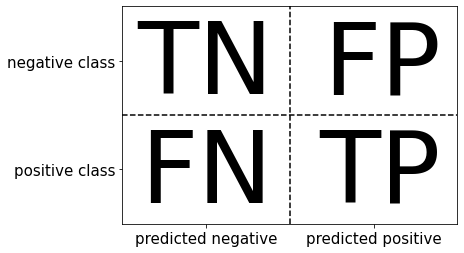

In [41]:
mglearn.plots.plot_binary_confusion_matrix()

In [42]:
print("Most frequent class:")
print(confusion_matrix(y_test,pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[368  35]
 [ 45   2]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[402   1]
 [  6  41]]


Looking at the confusion matrix, it is quite clear that something is wrong with
pred_most_frequent , because it always predicts the same class. pred_dummy , on the
other hand, has a very small number of true positives (4), particularly compared to
the number of false negatives and false positives—there are many more false positives
than true positives! The predictions made by the decision tree make much more
sense than the dummy predictions, even though the accuracy was nearly the same.
Finally, we can see that logistic regression does better than pred_tree in all aspects: it
has more true positives and true negatives while having fewer false positives and false
negatives. From this comparison, it is clear that only the decision tree and the logistic
regression give reasonable results, and that the logistic regression works better than
the tree on all accounts. However, inspecting the full confusion matrix is a bit
cumbersome, and while we gained a lot of insight from looking at all aspects of the
matrix, the process was very manual and qualitative. There are several ways to summarize
the information in the confusion matrix, which we will discuss next.

__Relation to accuracy__. We already saw one way to summarise the result
in the confusion matrix - by computing accuracy, which ban be expressed as:

$$ accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

In other words, accuracy is the number of correct predictions (TP and TN) divided by the number of
all samples (all entreis of the confusion matrix suumed up)

__Precision, recall and f-score__. There are several other ways to summarize the confusion matrix,
with the most common ones being precision and recall.

_Precision_ measures how mamny of the samples predicted as positive are actually positive:
$$ precision = \frac{TP}{TP + FP} $$

Precision is used as a performance metric when the goal is to limit the number of
false positives. As an example, imagine a model for predicting whether a new drug
will be effective in treating a disease in clinical trials. Clinical trials are notoriously
expensive, and a pharmaceutical company will only want to run an experiment if it is
very sure that the drug will actually work. Therefore, it is important that the model
does not produce many false positives—in other words, that it has a high precision.
Precision is also known as _positive predictive value_ (PPV).

_Recall_, on the other hand measures how many of the positive samples are
captures by the positive predictions:
    
$$ recall = \frac{TP}{TP + TN} $$

Recall is used as performance metric when we need to identify all positive samples;
that is, when it is important to avoid false negatives. The cancer diagnosis example
from earlier in this chapter is a good example for this: it is important to find all people that are sick, possibly including healthy patients in the prediction. Other names
for recall are _sensitivity_, _hit rate_, or _true positive rate_ (TPR).

So, while precision and recall are very important measures, looking at only one of
them will not provide you with the full picture. One way to summarize them is the
_f-score_ or _f-measure_, which is with the harmonic mean of precision and recall:

$$ F = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$

This particular variant is also know as the $f_1$-score. As it takes precision and recall
into account, it can be better measure than accuracy on imbalanced binary classification
datasets. Let's run it on the predictions for the "nive vs rest" dataset that we
computed earlier. Here, we will assume that the "nine" class is the positive class
(it is labeled as `True` while the rest is labeled as `False`), so the positive is the
minotiry class:

In [43]:
from sklearn.metrics import f1_score

print(f'f1 score most frequent: {f1_score(y_test, pred_most_frequent):.2f}')
print(f'f1 score most dummy: {f1_score(y_test, pred_dummy):.2f}')
print(f'f1 score most tree: {f1_score(y_test, pred_tree):.2f}')
print(f'f1 score most logistic reg: {f1_score(y_test, pred_logreg):.2f}')

f1 score most frequent: 0.00
f1 score most dummy: 0.05
f1 score most tree: 0.55
f1 score most logistic reg: 0.92


We can see a pretty strong distinction between
the dummy predictions and the tree predictions, which wasn’t clear when looking at
accuracy alone. Using the f-score for evaluation, we summarized the predictive per‐
formance again in one number. However, the f-score seems to capture our intuition
of what makes a good model much better than accuracy did. A disadvantage of the
f-score, however, is that it is harder to interpret and explain than accuracy.

If we want a more comprehensive summary of precision, recall, and f 1 -score, we can
use the classification_report convenience function to compute all three at once,
and print them in a nice format:

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,
                            target_names = ['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification_report function produces one line per class (here, True and
False ) and reports precision, recall, and f-score with this class as the positive class.
Before, we assumed the minority “nine” class was the positive class. If we change the
positive class to “not nine,” we can see from the output of classification_report
that we obtain an f-score of 0.94 with the most_frequent model. Furthermore, for the
“not nine” class we have a recall of 1, as we classified all samples as “not nine.” The
last column next to the f-score provides the support of each class, which simply means
the number of samples in this class according to the ground truth.
The last row in the classification report shows a weighted (by the number of samples
in the class) average of the numbers for each class. Here are two more reports, one for
the dummy classifier and one for the logistic regression:

In [45]:
print(classification_report(y_test, pred_dummy,
                            target_names = ['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.89      0.91      0.90       403
        nine       0.05      0.04      0.05        47

    accuracy                           0.82       450
   macro avg       0.47      0.48      0.47       450
weighted avg       0.80      0.82      0.81       450



In [46]:
print(classification_report(y_test, pred_logreg,
                            target_names = ['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



As you may notice when looking at the reports, the differences between the dummy
models and a very good model are not as clear any more. Picking which class is
declared the positive class has a big impact on the metrics. While the f-score for the
dummy classification is 0.13 (vs. 0.89 for the logistic regression) on the “nine” class,
for the “not nine” class it is 0.90 vs. 0.99, which both seem like reasonable results.
Looking at all the numbers together paints a pretty accurate picture, though, and we
can clearly see the superiority of the logistic regression model.

### __Taking uncertainty into account__

The confusion matrix and the classification report provide a very detailed analysis of
a particular set of predictions. However, the predictions themselves already threw
away a lot of information that is contained in the model. As we discussed in Chapter 2,
most classifiers provide a `decision_function` or a `predict_proba` method to
assess degrees of certainty about predictions. Making predictions can be seen as
thresholding the output of `decision_function` or `predict_proba` at a certain fixed
point—in binary classification we use 0 for the decision function and 0.5 for
`predict_proba` .

The following is an example of an imbalanced binary classification task, with 400
points in the negative class classified against 50 points in the positive class.
We train a kernel SVM model on this
data, and the plots to the right of the training data illustrate the values of the decision
function as a heat map. You can see a black circle in the plot in the top center, which
denotes the threshold of the `decision_function` being exactly zero. Points inside this
circle will be classified as the positive class, and points outside as the negative class:

In [47]:
from mglearn.datasets import make_blobs

X, y = make_blobs(
    n_samples = (400, 500), centers = 2, cluster_std = [7.0, 2],
    random_state = 22
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 0
)

svc = SVC(gamma = 0.05).fit(X_train, y_train)

/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


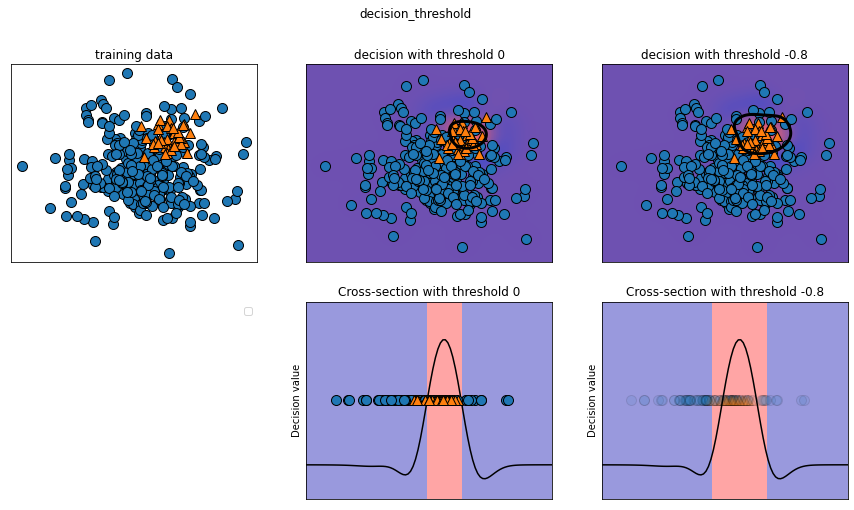

In [48]:
mglearn.plots.plot_decision_threshold()

In [49]:
# we can use the classification_report function to
# evluate precision and recall for both classes
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       100
           1       0.89      1.00      0.94       125

    accuracy                           0.93       225
   macro avg       0.95      0.93      0.93       225
weighted avg       0.94      0.93      0.93       225



Let’s assume in our application it is more important to have a high recall for class 0, as
in the cancer screening example earlier. This means we are willing to risk more false
positives (false class 0) in exchange for more true positives (which will increase the
recall). The predictions generated by svc.predict really do not fulfill this require‐
ment, but we can adjust the predictions to focus on a higher recall of class 0 by
changing the decision threshold away from 0. By default, points with a deci
sion_function value greater than 0 will be classified as class 0. We want more points
to be classified as class 0, so we need to decrease the threshold:

In [50]:
y_pred_lower_threshold = svc.decision_function(X_test) > 0.9

In [51]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       100
           1       0.92      0.90      0.91       125

    accuracy                           0.90       225
   macro avg       0.90      0.90      0.90       225
weighted avg       0.90      0.90      0.90       225



As expected, the recall of class 0 went up, and the precision went down.
If you value precision over recall or the other way around, or your data is
heavily imbalanced, changing the decision threshold is the easiest way to obtain bet‐
ter results. As the decision_function can have arbitrary ranges, it is hard to provide
a rule of thumb regarding how to pick a threshold.

If you do set a threshold, you need to be careful not to do so using
the test set. As with any other parameter, setting a decision thresh‐
old on the test set is likely to yield overly optimistic results. Use a
validation set or cross-validation instead.

Picking a threshold for models that implement the `predict_proba` method can be
easier, as the output of `predict_proba` is on a fixed 0 to 1 scale, and models probabil‐
ities. By default, the threshold of 0.5 means that if the model is more than 50% “sure”
that a point is of the positive class, it will be classified as such. Increasing the thresh‐
old means that the model needs to be more confident to make a positive decision
(and less confident to make a negative decision). While working with probabilities
may be more intuitive than working with arbitrary thresholds, not all models provide
realistic models of uncertainty (a `DecisionTree` that is grown to its full depth is
always 100% sure of its decisions, even though it might often be wrong). This relates
to the concept of __calibration: a calibrated model is a model that provides an accurate
measure of its uncertainty.__

### __Precision-recall curves and ROC curves__

As we just discussed, changing the threshold that is used to make a classification
decision in a model is a way to adjust the trade-off of precision and recall for a given
classifier. Maybe you want to miss less than 10% of positive samples, meaning a desired
recall of 90%. This decision depends on the application, and it should be driven by
business goals. Once a particular goal is set—say, a particular recall or precision value
for a class—a threshold can be set appropriately. It is always possible to set a threshold
to fulfill a particular target, like 90% recall. The hard part is to develop a model
that still has reasonable precision with this threshold—if you classify everything as
positive, you will have 100% recall, but your model will be useless.
Setting a requirement on a classifier like 90% recall is often called setting the operating
point. Fixing an operating point is often helpful in business settings to make performance
guarantees to customers or other groups inside your organization.

Often, when developing a new model, it is not entirely clear what the operating point
will be. For this reason, and to understand a modeling problem better, it is instructive
to look at all possible thresholds, or all possible trade-offs of precision and recalls at
once. This is possible using a tool called the _precision-recall_ curve. You can find the
function to compute the precision-recall curve in the sklearn.metrics module. It
needs the ground truth labeling and predicted uncertainties, created via either
`decision_function` or `predict_proba` :

In [52]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test)
)

The `precision_recall_curve` function returns a list of precision and recall values
for all possible thresholds (all values that appear in the decision function) in sorted
order, so we can plot a curve:

/home/concerta/.virtualenvs/lab/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


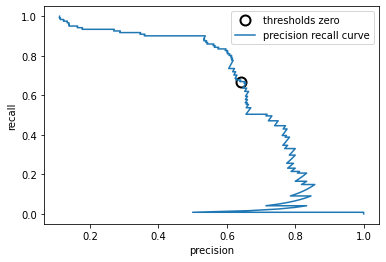

In [53]:
# sue more data points for a smoother curve
X, y = make_blobs(
    n_samples = (4000, 500), centers = 2, cluster_std = [7.0, 2],
    random_state = 22
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

svc = SVC(gamma = 0.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test)
)

# finds thresholds closes to zero
close_zero = np.argmin(np.abs(thresholds))

plt.plot(
    precision[close_zero], recall[close_zero], 'o', markersize = 10,
    label = 'thresholds zero', fillstyle = 'none', c = 'k', mew = 2
)

plt.plot(precision, recall, label = 'precision recall curve')
plt.legend()
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()

Each point along the curve in Figure 5-13 corresponds to a possible threshold of the
decision_function . We can see, for example, that we can achieve a recall of 0.4 at a
precision of about 0.75. The black circle marks the point that corresponds to a thresh‐
old of 0, the default threshold for decision_function . This point is the trade-off that
is chosen when calling the predict method.

The closer a curve stays to the upper-right corner, the better the classifier. A point at
the upper right means high precision and high recall for the same threshold. The
curve starts at the top-left corner, corresponding to a very low threshold, classifying
everything as the positive class. Raising the threshold moves the curve toward higher
precision, but also lower recall. Raising the threshold more and more, we get to a sit‐
uation where most of the points classified as being positive are true positives, leading
to a very high precision but lower recall. The more the model keeps recall high as
precision goes up, the better.

Looking at this particular curve a bit more, we can see that with this model it is possi‐
ble to get a precision of up to around 0.5 with very high recall. If we want a much
higher precision, we have to sacrifice a lot of recall. In other words, on the left the
curve is relatively flat, meaning that recall does not go down a lot when we require
increased precision. For precision greater than 0.5, each gain in precision costs us a
lot of recall.

Different classifiers can work well in different parts of the curve—that is, at different
operating points. Let’s compare the SVM we trained to a random forest trained on the
same dataset. The RandomForestClassifier doesn’t have a decision_function , only
predict_proba . The precision_recall_curve function expects as its second argu‐
ment a certainty measure for the positive class (class 1), so we pass the probability of
a sample being class 1—that is, rf.predict_proba(X_test)[:, 1] . The default
threshold for predict_proba in binary classification is 0.5, so this is the point we
marked on the curve:

/home/concerta/.virtualenvs/lab/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


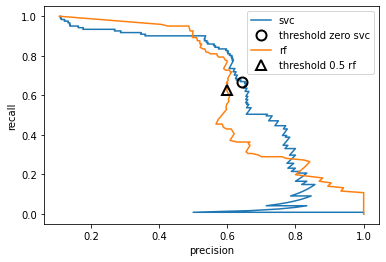

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 100, random_state = 0, max_features = 2
)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba,
# but has no decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1]
)

plt.plot(precision, recall, label = 'svc')

plt.plot(
    precision[close_zero], recall[close_zero], 'o', markersize = 10,
    label = 'threshold zero svc', fillstyle = 'none', c = 'k', mew = 2
)

plt.plot(precision_rf, recall_rf, label = 'rf')

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(
    precision_rf[close_default_rf], recall_rf[close_default_rf], '^',
    c = 'k', markersize = 10, label = 'threshold 0.5 rf', fillstyle = 'none',
    mew = 2
)

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc = 'best')
plt.show()

From the comparison plot we can see that the random forest performs
better at the extremes, for every high recall or very high precision requirements.
Around the middle (approximately precision = 0.7), the SVM performs better.
IF we only looked at the $f_1$-score to compare overlal performance, we would have missed these
subleties. The $f_1$-score captures one point on the precision-recall curve, the one
given by the default threshold:

In [55]:
print(f'f_1 score of random forest: {f1_score(y_test, rf.predict(X_test)):.3f}')
print(f'f_1 score of svc: {f1_score(y_test, svc.predict(X_test)):.3f}')

f_1 score of random forest: 0.610
f_1 score of svc: 0.656


Comparing two precision-recall curves provides a lot of detailed insight, but is a fairly
manual process. For automatic model comparison, we might want to summarize the
information contained in the curve, without limiting ourselves to a particular thresh‐
old or operating point. One particular way to summarize the precision-recall curve is
by computing the integral or area under the curve of the precision-recall curve, also
known as the average precision. (There are some minor technical differences between
the area under the precision-recall curve and average
precision. However, this explanation conveys the general idea) You can use the
`average_precision_score` function
to compute the average precision. Because we need to compute the ROC curve and
consider multiple thresholds, the result of decision_function or predict_proba
needs to be passed to `average_precision_score , not the result of predict :

In [56]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print(f'average precision of random forest: {ap_rf:.3f}')
print(f'average precision of svc: {ap_svc:.3f}')

average precision of random forest: 0.660
average precision of svc: 0.666


When averaging over all possible thresholds, we see that the random forest and SVC
perform similarly well, with the random forest even slightly ahead. This is quite dif‐
ferent from the result we got from f1_score earlier. Because average precision is the
area under a curve that goes from 0 to 1, average precision always returns a value
between 0 (worst) and 1 (best). The average precision of a classifier that assigns
decision_function at random is the fraction of positive samples in the dataset.

### Receiver operating characteristics (ROC) and AUC

There is another tool that is commonly used to analyze the behavior of classifiers at
different thresholds: the receiver operating characteristics curve, or ROC curve for
short. Similar to the precision-recall curve, the ROC curve considers all possible
thresholds for a given classifier, but instead of reporting precision and recall, it shows
the false positive rate (FPR) against the true positive rate (TPR). Recall that the true
positive rate is simply another name for recall, while the false positive rate is the
fraction of false positives out of all negative samples:

$$ FPR = \frac{FP}{FP + TN} $$

The ROC curve can be computed using the roc_curve function

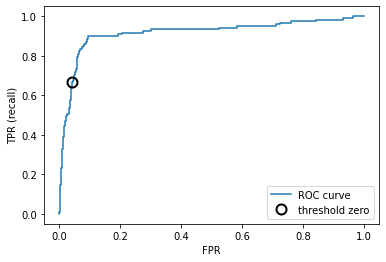

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR (recall)')

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(
    fpr[close_zero], tpr[close_zero], 'o', markersize = 10,
    label = 'threshold zero', fillstyle = 'none', c = 'k', mew = 2
)

plt.legend(loc = 'best')
plt.show()

For the ROC curve, the ideal curve is close to the top left: you want a classifier that
produces a high recall while keeping a low false positive rate. Compared to the default
threshold of 0, the curve shows that we can achieve a significantly higher recall
(around 0.9) while only increasing the FPR slightly. The point closest to the top left
might be a better operating point than the one chosen by default. Again, be aware that
choosing a threshold should not be done on the test set, but on a separate validation
set.

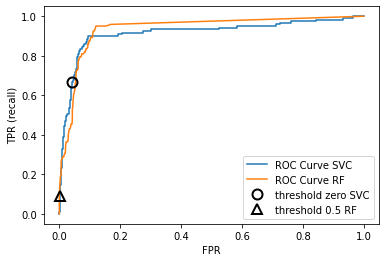

In [58]:
# comparison of random forest and svm using ROC
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thesholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label = 'ROC Curve SVC')
plt.plot(fpr_rf, tpr_rf, label = 'ROC Curve RF')

plt.xlabel('FPR')
plt.ylabel('TPR (recall)')
plt.plot(
    fpr[close_zero], tpr[close_zero], 'o', markersize = 10,
    label = 'threshold zero SVC', fillstyle = 'none', c = 'k', mew = 2
)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.05))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize = 10,
         label = 'threshold 0.5 RF', fillstyle = 'none', c = 'k', mew = 2
)

plt.legend(loc = 4)
plt.show()

In [59]:
# left on page 294 (308 of 392)

As for the precision-recall curve, we often want to summarize the ROC curve using a
single number, the area under the curve (this is commonly just referred to as the
AUC, and it is understood that the curve in question is the ROC curve). We can com
pute the area under the ROC curve using the roc_auc_score function:

In [60]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print(f'AUC for Random Forest: {rf_auc:.2f}')
print(f'AUC for SVC: {svc_auc:.2f}')

AUC for Random Forest: 0.94
AUC for SVC: 0.92


Comparing the random forest and SVM using the AUC score, we find that the
random forest performs quite a bit better than the SVM. Recall that because average
precision is the area under a curve that goes from 0 to 1, average precision always returns
a value between 0 (worst) and 1 (best). Predicting randomly always produces an AUC
of 0.5, no matter how imbalanced the classes in a dataset are. This makes AUC a
much better metric for imbalanced classification problems than accuracy. The AUC
can be interpreted as evaluating the ranking of positive samples. It’s equivalent to the
probability that a randomly picked point of the positive class will have a higher score
according to the classifier than a randomly picked point from the negative class. So, a
perfect AUC of 1 means that all positive points have a higher score than all negative
points. For classification problems with imbalanced classes, using AUC for model
selection is often much more meaningful than using accuracy.

gamma: 1.00  accuracy: 0.90  auc = 0.5000
gamma: 0.15  accuracy: 0.90  auc = 0.7889
gamma: 0.01  accuracy: 0.90  auc = 0.9995


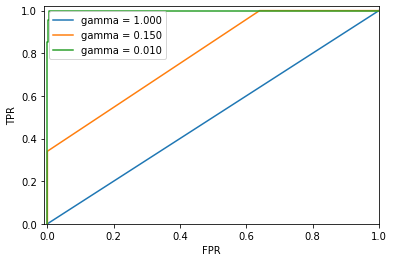

In [72]:
# classify the dataset (digits) with an SVM
# with three different settings of the kernel bandwith, gamma
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state = 0
)

plt.figure()

for gamma in [1, 0.15, 0.01]:
    svc = SVC(gamma = gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, __ = roc_curve(y_test, svc.decision_function(X_test))
    print(f'gamma: {gamma:.2f}  accuracy: {accuracy:.2f}  auc = {auc:.4f}')
    plt.plot(fpr, tpr, label = f'gamma = {gamma:.3f}')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc = 'best')
plt.show()

The accuracy of all three settings of gamma is the same, 90%. This might be the same
as chance performance, or it might not. Looking at the AUC and the corresponding
curve, however, we see a clear distinction between the three models. With `gamma = 1.0` ,
the AUC is actually at chance level, meaning that the output of the `decision_func
tion` is as good as random. With `gamma = 0.15` , performance drastically improves to an
AUC of 0.79. Finally, with `gamma = 0.01`, we get a perfect AUC of 1.0 (0.9995). That means that
all positive points are ranked higher than all negative points according to the decision
function. In other words, with the right threshold, this model can classify the data
perfectly! Knowing this, we can adjust the threshold on this model and obtain great
predictions. If we had only used accuracy, we would never have discovered this.

For this reason, we highly recommend using AUC when evaluating models on imbal‐
anced data. Keep in mind that AUC does not make use of the default threshold,
though, so adjusting the decision threshold might be necessary to obtain useful classi‐
fication results from a model with a high AUC.

## __Metrics for Multiclass Classification__

Basically, all metrics for
multiclass classification are derived from binary classification metrics, but averaged
over all classes. Accuracy for multiclass classification is again defined as the fraction
of correctly classified examples. And again, when classes are imbalanced, accuracy is
not a great evaluation measure. Imagine a three-class classification problem with 85%
of points belonging to class A, 10% belonging to class B, and 5% belonging to class C.
What does being 85% accurate mean on this dataset? In general, multiclass
classification results are harder to understand than binary classification results. Apart from
accuracy, common tools are the confusion matrix and the classification report we saw
in the binary case in the previous section. Let’s apply these two detailed evaluation
methods on the task of classifying the 10 different handwritten digits in the digits
dataset:

In [78]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state = 0
)

lr = LogisticRegression(max_iter = 9000).fit(X_train, y_train)

pred = lr.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, pred):.3f}')
print(f'confusion matrix:\n{confusion_matrix(y_test, pred)}')

accuracy: 0.953
confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  1  0 43  0]
 [ 0  0  0  0  0  1  0  0  2 44]]


The model has an accuracy of 95.3%, which already tells us that we are doing pretty
well. The confusion matrix provides us with some more detail.

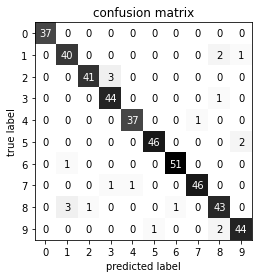

In [80]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel = 'predicted label',
    ylabel = 'true label', xticklabels = digits.target_names,
    yticklabels = digits.target_names, cmap = plt.cm.gray_r,
    fmt = '%d'
)

plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [82]:
# get the classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.92      0.98      0.95        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.90      0.90      0.90        48
           9       0.94      0.94      0.94        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



The most commonly used metric for imbalanced datasets in the multiclass setting is
the multiclass version of the f-score. The idea behind the multiclass f-score is to
compute one binary f-score per class, with that class being the positive class and the other
classes making up the negative classes. Then, these per-class f-scores are averaged
using one of the following strategies:

 + `macro` averaging computes the unweighted per-class $f$-scores.
    This gives equal weight to all classes, no matter what their size is. 
 + `weighted` averaging computes the mean of the per-class $f$-scores, weighted by
    their support. This is what is reported in the clsasificacion report.
 + `mico` averaging computed the total number of false positives, false negatives,
    and true positives over all classes, and then computes precision, recall
    and $f$-score using these counts.
    
If you care about each sample equally much, it is recommended to use the "micro"
average f 1 -score; if you care about each class equally much, it is recommended to use
the "macro" average $f1$-score:

In [85]:
print(f'micro average f1 score: {f1_score(y_test, pred, average = "micro"):3f}')
print(f'micro average f1 score: {f1_score(y_test, pred, average = "macro"):3f}')

micro average f1 score: 0.953333
micro average f1 score: 0.954256


## __Regression Metrics__

Evaluation for regression can be done in similar detail as we did for classification—
for example, by analyzing overpredicting the target versus underpredicting the target.
However, in most applications we’ve seen, using the default R 2 used in the score
method of all regressors is enough. Sometimes business decisions are made on the
basis of mean squared error or mean absolute error, which might give incentive to
tune models using these metrics.

## __Using Evaluation Metrics in Model Selection__

We have discussed many evaluation methods in detail, and how to apply them given
the ground truth and a model. However, we often want to use metrics like AUC in
model selection using GridSearchCV or cross_val_score . Luckily scikit-learn
provides a very simple way to achieve this, via the scoring argument that can be used
in both GridSearchCV and cross_val_score . You can simply provide a string
describing the evaluation metric you want to use. Say, for example, we want to
evaluate the SVM classifier on the “nine vs. rest” task on the digits dataset, using the AUC
score. Changing the score from the default (accuracy) to AUC can be done by
providing "roc_auc" as the scoring parameter:


In [87]:
# default scoring for classification is accuracy
print(f'default scoring: {cross_val_score(SVC(), digits.data, digits.target == 9)}')

# providing scoring='accuracy' doen't change the results
explict_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9,
                                   scoring = 'accuracy')

print(f'explicit accuracy scoring: {explict_accuracy}')

roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9,
                          scoring = 'roc_auc')

print(f'AUC scoring: {roc_auc}')

default scoring: [0.975 0.992 1.    0.994 0.981]
explicit accuracy scoring: [0.975 0.992 1.    0.994 0.981]
AUC scoring: [0.997 0.999 1.    1.    0.984]


In [88]:
# similarly we can change the metric used to pick the ebst
# parameters in GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state = 0
)

# we provide a somewhat bad grid to illustrate the point
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring accuracy:
grid = GridSearchCV(SVC(), param_grid = param_grid)
grid.fit(X_train, y_train)

print('Grid-Search with accuracy')
print('best params: ', grid.best_params_)
print('best cross-validation score (accuracy): ', grid.best_score_)
print('test set AUC: ', roc_auc_score(y_test, grid.decision_function(X_test)))
print('test set accuracy: ', grid.score(X_test, y_test))

Grid-Search with accuracy
best params:  {'gamma': 0.0001}
best cross-validation score (accuracy):  0.975500481894534
test set AUC:  0.9919222849902327
test set accuracy:  0.9733333333333334


In [89]:
# using AUC scoring instead
grid = GridSearchCV(SVC(), param_grid = param_grid, scoring = 'roc_auc')
grid.fit(X_train, y_train)

print('Grid-Search with accuracy')
print('best params: ', grid.best_params_)
print('best cross-validation score (accuracy): ', grid.best_score_)
print('test set AUC: ', roc_auc_score(y_test, grid.decision_function(X_test)))
print('test set accuracy: ', grid.score(X_test, y_test))

Grid-Search with accuracy
best params:  {'gamma': 0.01}
best cross-validation score (accuracy):  0.997999457969529
test set AUC:  0.999524840293543
test set accuracy:  0.999524840293543


When using accuracy, the parameter `gamma = 0.0001` is selected, while `gamma = 0.01` is
selected when using AUC. The cross-validation accuracy is consistent with the test set
accuracy in both cases. However, using AUC found a better parameter setting in
terms of AUC and even in terms of accuracy.

The most important values for the scoring parameter for classification are accuracy
(the default); `roc_auc` for the area under the ROC curve; `average_precision` for the
area under the precision-recall curve; `f1` , `f1_macro` , `f1_micro` , and `f1_weighted` for
the binary $f1$-score and the different weighted variants. For regression, the most com‐
monly used values are `r2` for the $R^2$ score, `mean_squared_error` for mean squared
error, and `mean_absolute_error` for mean absolute error.

In [91]:
from sklearn.metrics import SCORERS
print(sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']
